In [405]:
import numpy as np

In [406]:
import matplotlib.pyplot as plt
from matplotlib import rc

plt.rcParams["figure.figsize"] = [6, 6]
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def fix_scaling(ax=None):
    if not ax:
        xlim = plt.xlim()
        ylim = plt.ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            plt.ylim((ylim[0] - (d1 - d2) / 2, ylim[1] + (d1 - d2) / 2))
        else:
            plt.xlim((xlim[0] + (d1 - d2) / 2, xlim[1] - (d1 - d2) / 2))
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            ax.set_ylim((ylim[0] - (d1 - d2) / 2, ylim[1] + (d1 - d2) / 2))
        else:
            ax.set_xlim((xlim[0] + (d1 - d2) / 2, xlim[1] - (d1 - d2) / 2))

In [407]:
#1.1
a = ord("G") - ord("A") + 1
b = ord("B") - ord("A") + 1

def func(x):
    return a * x[0] ** 2 + b * (x[0] - x[1]) ** 2 - x[0] - 2 * x[1]

def f_grad(x):
    return np.array([2 * a * x[0] + 2 * b * (x[0] - x[1]) - 1, 2 * b * (x[1] - x[0]) - 2])

f_grad2 = np.array([[2 * (a + b), -2 * b], [-2 * b, 2 * b]])

min_point = [3 / (2 * a), 3 / (2 * a) + 1 / b]

lambdas = list(np.linalg.eigvals(f_grad2))
print(lambdas)

[19.06225774829855, 2.93774225170145]


In [408]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_trajectory(trajectories, labels=None):
    fig, ax = plt.subplots()
    
    if type(trajectories[0]) != list:
        trajectories = [trajectories]
    
    n = len(trajectories[0])

    def step(t):
        ax.cla()
        ax.plot([min_point[0]], [min_point[1]], 'o', color='green')
        # Level contours
        delta = 0.025
        x = np.arange(-10, 4, delta)
        y = np.arange(-4, 5, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        # print(X.shape, Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [3, 10, 25], colors=["blue", "purple", "red"])

        for i in range(len(trajectories)):
            if labels != None:
                ax.plot([u[0] for u in trajectories[i][:t]], [u[1] for u in trajectories[i][:t]], label=labels[i])
            else:
                ax.plot([u[0] for u in trajectories[i][:t]], [u[1] for u in trajectories[i][:t]])
            ax.plot([u[0] for u in trajectories[i][:t]], [u[1] for u in trajectories[i][:t]], 'o')
        
        if labels != None:
            plt.legend()
        fix_scaling(ax)
        ax.axis('off')

    return FuncAnimation(fig, step, frames=range(n), interval=600)

In [409]:
#1.2.0
start_point = np.array([-1, 4])

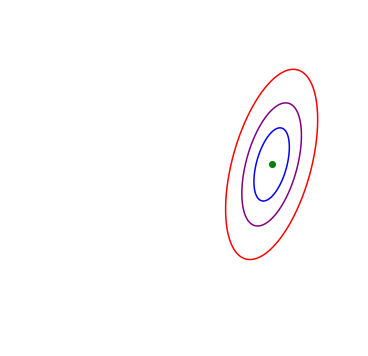

In [410]:
#1.2.1 optimal step
def traj_optimal_step(start_point):
    alpha = 2.0 / (sum(lambdas))
    traj = []
    cur_x = start_point.copy()
    traj.append(cur_x.copy())
    for i in range(15):
        cur_x = cur_x - alpha * f_grad(cur_x)
        traj.append(cur_x.copy())
    return traj
    
traj = traj_optimal_step(start_point)
base_animation = animate_trajectory(traj)
HTML(base_animation.to_html5_video())

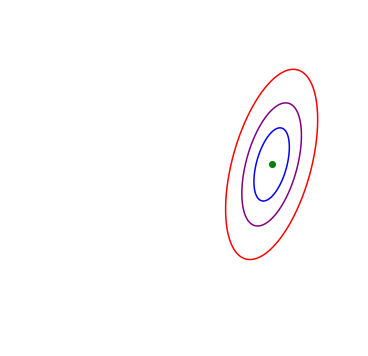

In [411]:
# 1.2.2 chebyshev
def traj_chebyshev(start_point):
    phi = (lambdas[0] + lambdas[1]) / (lambdas[0] - lambdas[1])
    cur_gamma = 1.0 / phi
    prev_gamma = 0
    traj = []
    cur_x = start_point.copy()
    traj.append(cur_x.copy())
    prev_x = cur_x.copy()
    for i in range(15):
        t = cur_x
        alpha = 4 * cur_gamma / (lambdas[0] - lambdas[1])
        beta = cur_gamma * prev_gamma
        cur_x = cur_x - alpha * f_grad(cur_x) + beta * (cur_x - prev_x)
        prev_x = t
        t = cur_gamma
        cur_gamma = 1.0 / (2 * phi - cur_gamma)
        prev_gamma = t
        traj.append(cur_x.copy())
    return traj
    
traj = traj_chebyshev(start_point)
base_animation = animate_trajectory(traj)
HTML(base_animation.to_html5_video())

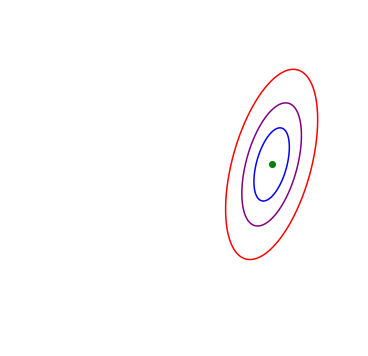

In [412]:
# 1.2.3 heavy ball
def traj_heavy_ball(start_point):
    alpha = 4.0 / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1])) ** 2
    beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
    traj = []
    cur_x = start_point.copy()
    traj.append(cur_x.copy())
    prev_x = cur_x.copy()
    for i in range(15):
        t = cur_x
        cur_x = cur_x - alpha * f_grad(cur_x) + beta * (cur_x - prev_x)
        prev_x = t
        traj.append(cur_x.copy())
    return traj
    
traj = traj_heavy_ball(start_point)
base_animation = animate_trajectory(traj)
HTML(base_animation.to_html5_video())

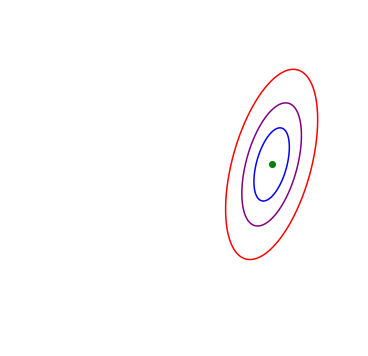

In [413]:
# 1.2.4 nesterov
def traj_nesterov(start_point):
    alpha = 1 / (lambdas[0] + 1)
    beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
    traj = []
    cur_x = start_point.copy()
    traj.append(cur_x.copy())
    cur_y = cur_x.copy()
    for i in range(15):
        t = cur_x
        cur_x = cur_y - alpha * f_grad(cur_y)
        cur_y = cur_x + beta * (cur_x - t)
        traj.append(cur_x.copy())
    return traj
    
traj = traj_nesterov(start_point)
base_animation = animate_trajectory(traj)
HTML(base_animation.to_html5_video())

In [414]:
#1.3.1
matrix_A = [[2 * (a + b), -2 * b], [-2 * b, 2 * b]]
vector_b = [1, 2] 
min_point = np.linalg.solve(matrix_A, vector_b)
min_val = func(min_point)
print(min_point, min_val)

[0.21428571 0.71428571] -0.8214285714285714


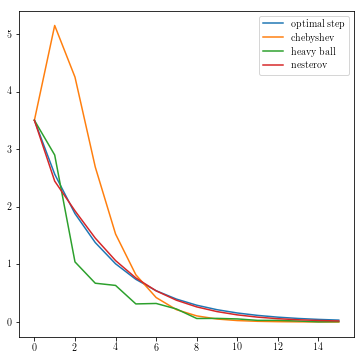

In [415]:
#1.3.2
fig, ax = plt.subplots()
u = traj_optimal_step(start_point)
ax.plot(range(16), [np.linalg.norm(t - min_point) for t in u], label="optimal step")
u = traj_chebyshev(start_point)
ax.plot(range(16), [np.linalg.norm(t - min_point) for t in u], label="chebyshev")
u = traj_heavy_ball(start_point)
ax.plot(range(16), [np.linalg.norm(t - min_point) for t in u], label="heavy ball")
u = traj_nesterov(start_point)
ax.plot(range(16), [np.linalg.norm(t - min_point) for t in u], label="nesterov")
plt.legend()
plt.plot()
plt.show()

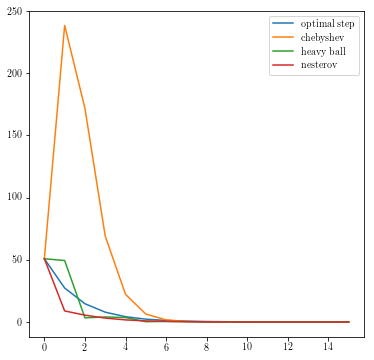

In [416]:
#1.3.3
fig, ax = plt.subplots()
u = traj_optimal_step(start_point)
ax.plot(range(16), [np.linalg.norm(func(t) - min_val) for t in u], label="optimal step")
u = traj_chebyshev(start_point)
ax.plot(range(16), [np.linalg.norm(func(t) - min_val) for t in u], label="chebyshev")
u = traj_heavy_ball(start_point)
ax.plot(range(16), [np.linalg.norm(func(t) - min_val) for t in u], label="heavy ball")
u = traj_nesterov(start_point)
ax.plot(range(16), [np.linalg.norm(func(t) - min_val) for t in u], label="nesterov")
plt.legend()
plt.plot()
plt.show()

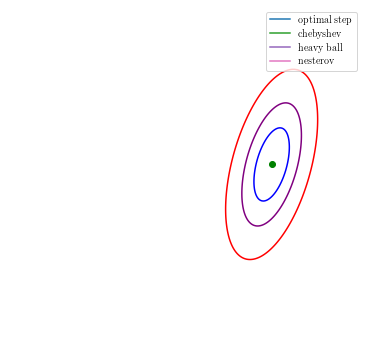

In [417]:
#1.3.4
trajectories = []
labels = []
trajectories.append(traj_optimal_step(start_point))
labels.append("optimal step")
trajectories.append(traj_chebyshev(start_point))
labels.append("chebyshev")
trajectories.append(traj_heavy_ball(start_point))
labels.append("heavy ball")
trajectories.append(traj_nesterov(start_point))
labels.append("nesterov")

base_animation = animate_trajectory(trajectories, labels)
HTML(base_animation.to_html5_video())

In [418]:
#2.1
def func(x):
    return np.e ** (x[0] + 3 * x[1]) + np.e ** (x[0] - 3 * x[1]) + np.e ** (-x[0])

def f_grad(x):
    return np.array([np.e ** (x[0] + 3 * x[1]) + np.e ** (x[0] - 3 * x[1]) - np.e ** (-x[0]),
                     3 * (np.e ** (x[0] + 3 * x[1]) - np.e ** (x[0] - 3 * x[1]))])

min_point = [-np.log(2) / 2, 0]

In [319]:
#2.2.1
def get_lipschitz(corner, length):
    lipschitz = 0
    for i in range(1000000):
        p1 = corner + np.random.rand(2) * length
        p2 = corner + np.random.rand(2) * length
        norm_points = np.linalg.norm(p1 - p2)
        norm_f = np.linalg.norm(f_grad(p1) - f_grad(p2))
        new_lipschitz = norm_f / norm_points
        lipschitz = max(lipschitz, new_lipschitz)
    return lipschitz

In [320]:
#2.2.2
corner = np.array([-1, -1])
length = 2
lipschitz = get_lipschitz(corner, length)
print(lipschitz)

427.4182117617438


In [321]:
#2.3.0
start_point = np.array([-1, 1])

2.82842712474619


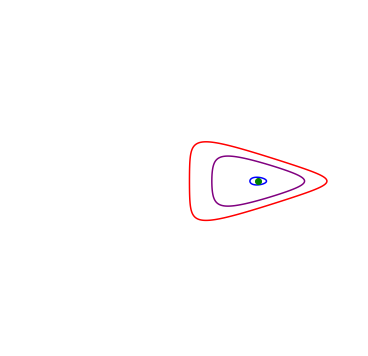

In [322]:
#2.3.1 optimal step
def traj_optimal_step(start_point):
    M = lipschitz
    alpha = 2.0 / M
    traj = []
    cur_x = start_point.copy()
    traj.append(cur_x.copy())
    for i in range(15):
        cur_x = cur_x - alpha * f_grad(cur_x)
        traj.append(cur_x.copy())
    return traj
    
traj = traj_optimal_step(start_point)
base_animation = animate_trajectory(traj)
HTML(base_animation.to_html5_video())

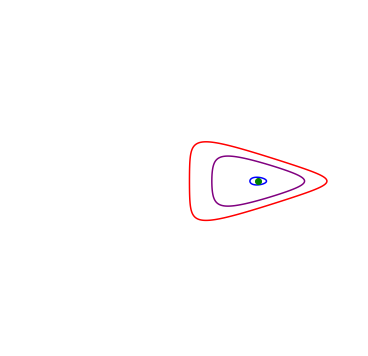

In [324]:
# 2.3.2 nesterov
def traj_nesterov(start_point):
    M = lipschitz
    alpha = 1 / M
    traj = []
    cur_x = start_point.copy()
    traj.append(cur_x.copy())
    cur_y = cur_x.copy()
    cur_alpha = 0.9
    for i in range(15):
        t_x = cur_x
        cur_x = cur_y - alpha * f_grad(cur_y)
        t_alpha = cur_alpha
        cur_alpha = 0.5 * (cur_alpha * np.sqrt(cur_alpha ** 2 + 4) - cur_alpha ** 2)
        beta = t_alpha * (1 - t_alpha) / (t_alpha ** 2 + cur_alpha)
        cur_y = cur_x + beta * (cur_x - t_x)
        traj.append(cur_x.copy())
    return traj
    
traj = traj_nesterov(start_point)
base_animation = animate_trajectory(traj)
HTML(base_animation.to_html5_video())

In [182]:
#3.1.1
def polynomial_regression(xs, ys, deg):
    n = len(xs)
    G = np.zeros([n, deg + 1])
    for i in range(n):
        G[i][0] = 1
        for j in range(deg):
            G[i][j + 1] = G[i][j] * xs[i]
    return np.linalg.solve(np.matmul(np.transpose(G), G), np.matmul(np.transpose(G), ys))

In [183]:
#3.1.2
def polynomial_3(x):
    return 2 * x ** 3 - 3 * x **2 + 4
xs = list(range(10))
ys = [polynomial_3(x) for x in xs]
deg = 3
result = polynomial_regression(xs, ys, deg)
for i in range(len(result)):
    print(result[i])

4.000000000003241
-5.663063600945726e-12
-2.999999999998401
1.9999999999998845


In [403]:
#3.2.1
def optimal_circle(xs, ys):
    n = len(xs)
    
    def func(x):
        err = 0
        for i in range(n):
            err += (np.sqrt((x[0] - xs[i]) ** 2 + (x[1] - ys[i]) ** 2) - x[2]) ** 2
        return err

    def f_grad(x):
        grad = np.zeros(3)
        for i in range(n):
            d = np.sqrt((x[0] - xs[i]) ** 2 + (x[1] - ys[i]) ** 2)
            grad += np.array([ \
                2 * (x[0] -  xs[i]) * (d - x[2]) / d, \
                2 * (x[1] -  ys[i]) * (d - x[2]) / d, \
                2 * (x[2] - d) \
            ])
        return grad
        
    alpha = 0.001
    cur_x = np.array([ \
        xs.mean(), \
        ys.mean(), \
        np.sqrt((xs - xs.mean()) ** 2 + (ys - ys.mean()) ** 2).mean() \
    ])
    for i in range(100000):
        cur_x = cur_x - alpha * f_grad(cur_x)
    return cur_x
    

In [404]:
#3.2.2
x = 5
y = 4
r = 1
xs, ys = [], []
for i in range(10):
    v = np.random.rand(2)
    v = v / np.linalg.norm(v) * r
    xs.append(x + v[0])
    ys.append(y + v[1])
xs = np.array(xs)
ys = np.array(ys)
print(optimal_circle(xs, ys))

[5.00068387 4.00061687 0.99916419]
